In [1]:
import cv2
import mediapipe as mp
import urllib.request as urlreq
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse, Rectangle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from glob import glob
import pandas as pd

#from rembg import remove

from config import *
from cropping import *
from landmarks_utils import *
from preprocessing import *
from face_landmarking_model import *
from training import *
from face_dataset import FaceDataset, EnsembleSampler

In [2]:
# x_inp, y_inp, path_list, angles = prepare_training_landmarks()

In [3]:
# save_preprocessed_data(x_inp, y_inp, path_list, angles)

In [4]:
# Prepare best groups for ensemble projection
groups = [os.path.basename(os.path.normpath(path_string)) for path_string in glob("./AI_Morphometrics/*/", recursive = False)]
groups_results = pd.read_json('training_results_means.json', orient='index')
groups_results.columns = ['result']
list_df = pd.read_csv('./preprocessed_data/path_list.txt', names=['text'], header=None)
counts = {}
for group in groups:
    counts[group] = len(list_df[list_df['text'].str.contains(group)])
compare = pd.concat([groups_results, pd.DataFrame(counts.items(), columns=['group', 'sample']).set_index('group')], axis = 1)
#plt.scatter(x=compare['sample'], y=compare['result'])
num_selected_groups = 10
best_groups = compare.dropna().sort_values(by=['sample'])[-num_selected_groups:].sort_values(by=['result']).index.to_list()

In [10]:
model, optimizers, schedulers, datasets, dataloaders = prepare_trainers(best_groups, num_parent_landmarks = 10, projectors=5, rotate=True, lr=0.01)

creating datasets


In [19]:
cache = train(model,optimizers, schedulers, datasets, dataloaders)

start training
Epoch: 144, current loss: 0.0006680057849735022
 Epoch: 145, complete dataset loss: 0.0007419264293275774
 Epoch: 146, complete dataset loss: 0.0005657477304339409
 Epoch: 147, complete dataset loss: 0.0006759539828635752
 Epoch: 148, complete dataset loss: 0.0007564083789475262
 Epoch: 149, complete dataset loss: 0.0007757794810459018

In [18]:
# Upravit, zrušit opakování kódu pro různé training phases

def train (model, 
           optimizers, 
           schedulers, 
           datasets, 
           dataloaders, 
           pretraining = True,
           epochs = 150,
           pretrain_epochs = 150):
     
    actual_optimizers = [optimizers["ensemble"]]
    TRAIN_PHASE = 0
    PRETRAINING = pretraining

    cache = {}
    #cache["no_scheduler"] = []
    cache["scheduler"] = []

    print('start training')
    for epoch in range(epochs):

        if epoch == pretrain_epochs:
            PRETRAINING = False
            actual_optimizers = [optimizers["cnn"]]
            TRAIN_PHASE += 1
            print('\n Freezing raw_projection, training CNN_focusing.')

        if epoch == 600:
            model.train()
            actual_optimizers = [optimizers["ffn"]]
            TRAIN_PHASE += 1
            print('\n Freezing CNN_focusing, training top FFN.')

        if epoch == 800:
            actual_optimizers = [optimizers["ensemble"], optimizers["cnn"], optimizers["ffn"]]

        datasets["main"].pretraining = PRETRAINING
        model.train_phase = TRAIN_PHASE

        
        if PRETRAINING:
            ensemble_inputs = []
            ensemble_targets = []
            for data_loader in dataloaders["ensemble"]:
                batch = next(iter(data_loader))
                inputs, targets, _ = batch
                ensemble_inputs.append(inputs)
                ensemble_targets.append(targets)
            
            for optimizer in actual_optimizers:
                optimizer.zero_grad()
            
            _, final_loss, raw_loss = model(
                ensemble_inputs,
                targets = ensemble_targets,
                multicrop = None,
            )
                     
            cache["scheduler"].append(final_loss.item())
            final_loss.backward()

            for optimizer in actual_optimizers:
                optimizer.step()
            
            schedulers["ensemble"].step()
            
            if epoch < pretrain_epochs-5:
                print(f'Epoch: {epoch}, current loss: {final_loss}', end="\r")
            else:
                model.eval()
                batch = next(iter(dataloaders["main"]))
                inputs, targets, _ = batch
                
                _, total_loss, raw_loss = model(
                    ensemble_inputs,
                    targets = ensemble_targets,
                    multicrop = None,
                )

                print(f'\n Epoch: {epoch}, complete dataset loss: {total_loss}', end = "")
                
        
        else:
            for iteration, batch in enumerate(dataloaders["main"]):
                for optimizer in actual_optimizers:
                    optimizer.zero_grad()

                inputs, targets, multicrop = batch
                
                _, final_loss, raw_loss = model(
                    inputs,
                    targets = targets,
                    multicrop = multicrop,
                )

                cache["scheduler"].append(final_loss.item())
                final_loss.backward()

                for optimizer in actual_optimizers:
                    optimizer.step()
                

                if iteration == 0:

                    if epoch <= pretrain_epochs and epoch % 20 == 0:
                        print(f'Epoch: {epoch}, current loss: {final_loss}.')

                    if epoch > pretrain_epochs and epoch % 2 == 0:
                        print(f'Epoch: {epoch}, iteration: {iteration}, final loss: {final_loss}, raw loss: {raw_loss}.')
        
    return cache
        
    

tensor([2118])


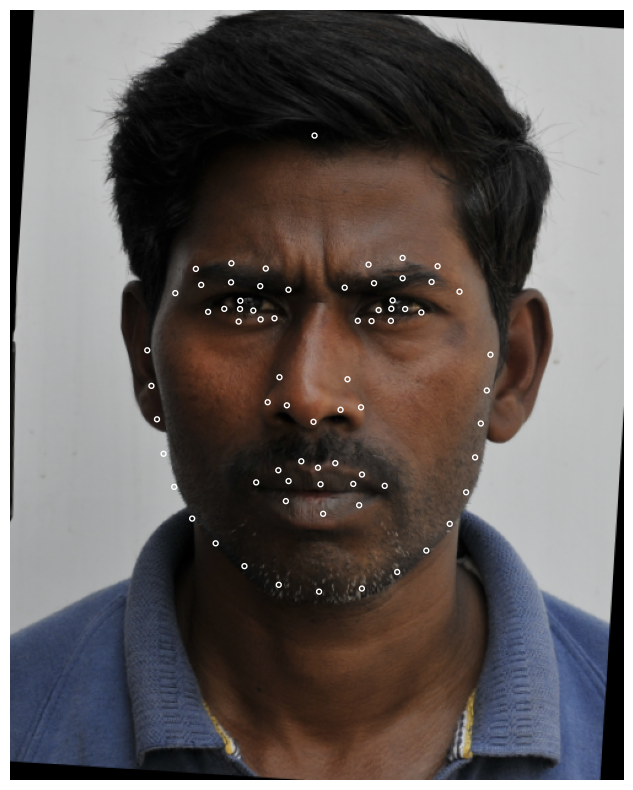

In [20]:
dataset = datasets["main"]
dataset.pretraining = False
idx = torch.randint(dataset.__len__(),(1,))
print(idx)
img_path = dataset.path_list[idx]
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
landmarks, inputs_pathway, image_detail = model.predict(image, face_detail=True)
landmarks = landmarks.reshape(-1,2)
display_landmarks(landmarks, image_detail, pixel_scale=False, origin='upper_left')



# display_landmarks(inputs_pathway.reshape(-1,2), image_detail, pixel_scale=False, origin='upper_left')

NameError: name 'i' is not defined

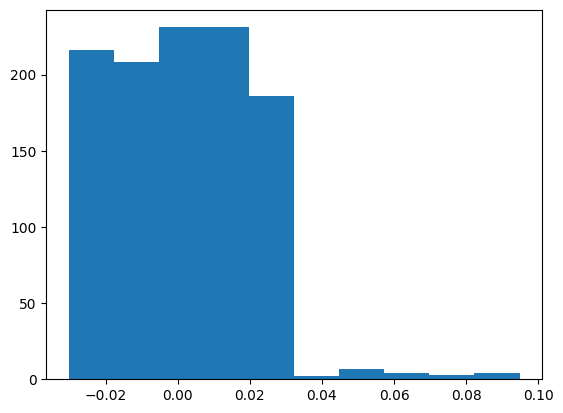

In [59]:
plt.hist(model.ensemble.ensemble[0].linear2.weight[0,:].detach().numpy())
i+=1


In [84]:
import torch
import torch.nn as nn

class SparsityLoss(nn.Module):
    def __init__(self, max_non_zero_connections, threshold=0.001):
        super(SparsityLoss, self).__init__()
        self.max_non_zero_connections = max_non_zero_connections
        self.threshold = threshold

    def forward(self, weight_matrix):
        # Calculate the L0 norm approximation using soft thresholding
        soft_threshold = torch.abs(weight_matrix) - self.threshold
        l0_norm = torch.sum(torch.relu(soft_threshold), dim=0)
        
        # Calculate the excess connections beyond the desired limit
        excess_connections = l0_norm - self.max_non_zero_connections
        
        # Define a penalty term to encourage sparsity
        penalty = torch.sum(torch.relu(excess_connections))
        return penalty

output_size = 10
max_non_zero_connections = 3  # Set your desired maximum non-zero connections
mask_matrix = torch.randint(0, 2, (output_size, output_size))

# Create a random weight matrix for illustration
weight_matrix = torch.randn(output_size, output_size, requires_grad=True)

# Initialize the custom sparsity loss
sparsity_loss = SparsityLoss(max_non_zero_connections)

masked_matrix = torch.mul(mask_matrix, weight_matrix)

# Calculate the sparsity penalty
penalty = sparsity_loss(masked_matrix)

print(penalty)

tensor(17.8332, grad_fn=<SumBackward0>)


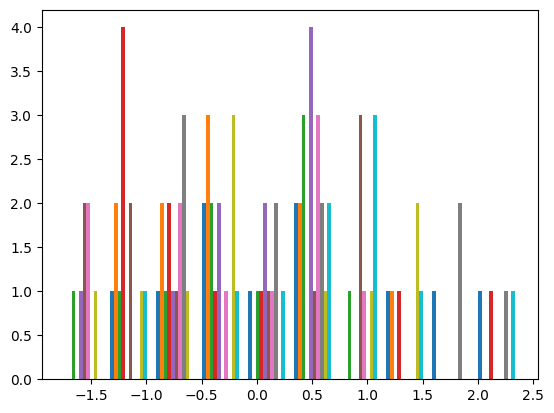

Optimized weight matrix:


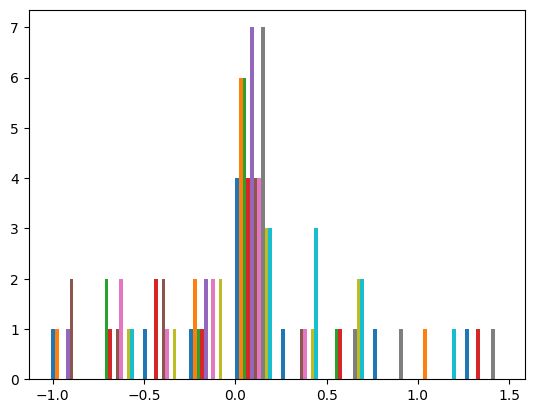

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
# Create your optimizer
output_size = 10
max_non_zero_connections = 3
weight_matrix = nn.Parameter(torch.randn(output_size, output_size))

optimizer = optim.SGD([weight_matrix], lr=0.01)
plt.hist(weight_matrix.squeeze().detach())
plt.show()

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Calculate the custom sparsity penalty
    loss = sparsity_loss(weight_matrix)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    # if (epoch + 1) % 100 == 0:
    #     print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item()}")

print("Optimized weight matrix:")
plt.hist(weight_matrix.squeeze().detach())
plt.show()

In [ ]:

def get_subimage_shape(image_path):
    width, height = imagesize.get(img_path)
    subimage_size = 2*torch.mul(size_measure, torch.tensor([width, height])).squeeze()
    new_width = STANDARD_IMAGE_WIDTH
    scale = new_width / subimage_size[0]
    new_height = int(scale * subimage_size[1])
    return torch.tensor([new_height, new_width])

get_subimage_shape(img_path)

tensor(0.4671)


tensor([618, 500])

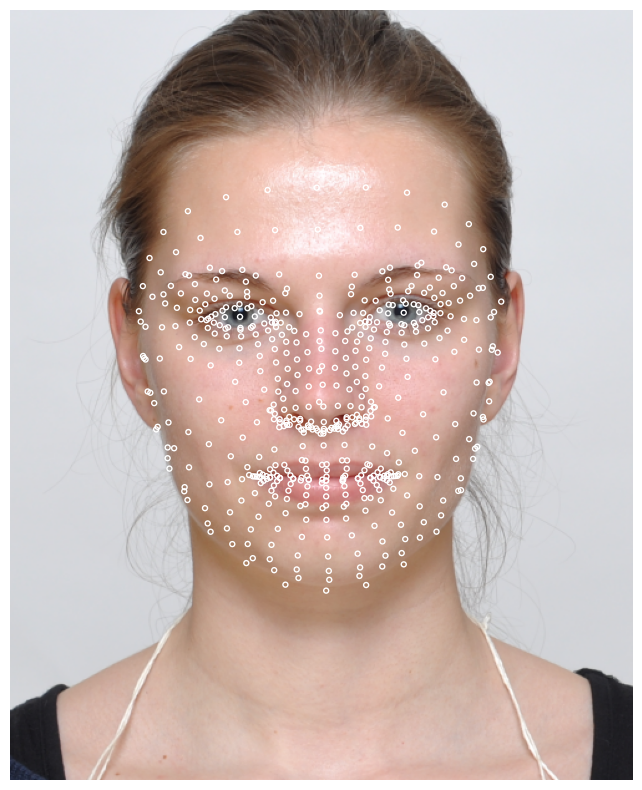

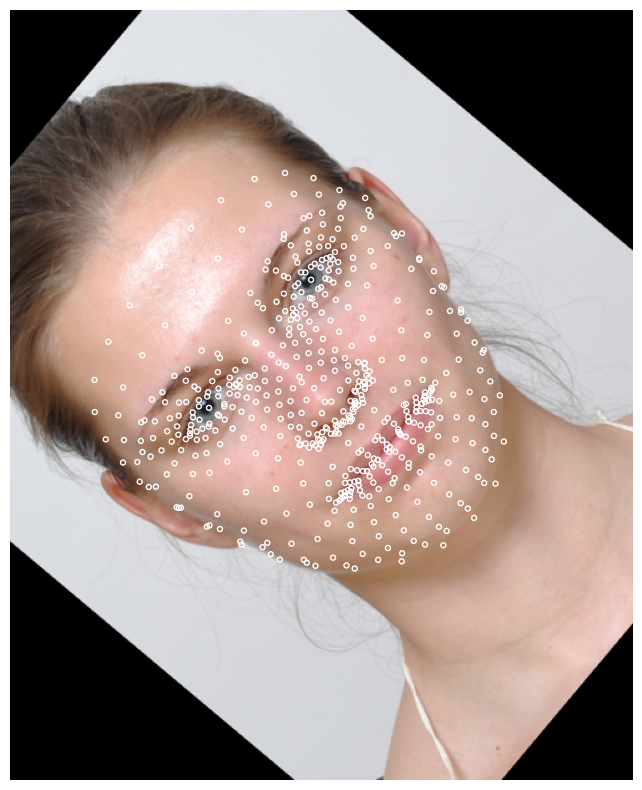

In [ ]:
alpha = 50
display_landmarks(relative_landmarks, subimage, pixel_scale=False, origin='upper_left')
rotated_image = rotate_image(alpha, subimage)
landmarks = rotate_landmarks(alpha, relative_landmarks, (new_height, new_width))
display_landmarks(landmarks, rotated_image, pixel_scale=False, origin='upper_left')

In [ ]:
@torch.no_grad()
def show_some_results(group = None, idx = None):
    if group is None:
        group = sample_groups[np.random.randint(len(sample_groups))]
    
    for file in os.listdir(group):
        if '.TPS' in file or '.tps' in file:
             tps = readtps(group + '/' + file, group)
        
    if idx is None:
        idx = np.random.randint(len(tps['im']))
        
    true_landmarks = tps['coords'][:, :, idx]
    img_path = group + '/' + tps['im'][idx]
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    face_detail = crop_face_only(image)
    if face_detail:
        subimage, xmin, ymin, xmax, ymax = face_detail
    
    # Both model use float(0,1) for x and y axis
    input_landmarks = MediaPipe_model(subimage)
    #input_landmarks = np.concatenate((LBF_model(image), MediaPipe_model(image)), axis = 0)

    #true_landmarks = np.subtract(true_landmarks, (xmin, image.shape[0] - ymax))
    #true_landmarks = np.divide(true_landmarks, (subimage.shape[1], subimage.shape[0]))
     
    # Převod původních pixelových na float, flip y-axis
    true_landmarks = torch.from_numpy(1 - np.divide(true_landmarks, (image.shape[1], image.shape[0]))).to(device)

    # batch_dim = 0
    input_landmarks = torch.from_numpy(input_landmarks.reshape(1,-1)).float().to(device)
    raw_landmarks, _ = model.raw_projection(input_landmarks, None)

    multicrop = make_landmark_crops(raw_landmarks, subimage)
    
    #předělat a použít prediction method
    projection, _, _ = model(input_landmarks, true_landmarks.reshape(1,-1), multicrop = multicrop[None,:,:,:], image_shape = subimage.shape)
    projection = projection.cpu().detach().numpy().reshape(true_landmarks.shape)
    
    # tady připočíst xmin a ten druhý pól image_shape - ymax
    return projection, image, true_landmarks, raw_landmarks

In [ ]:
model.eval()
idx = -1

In [ ]:
idx += 10

In [ ]:
proj, im, y, raw = show_some_results(idx)

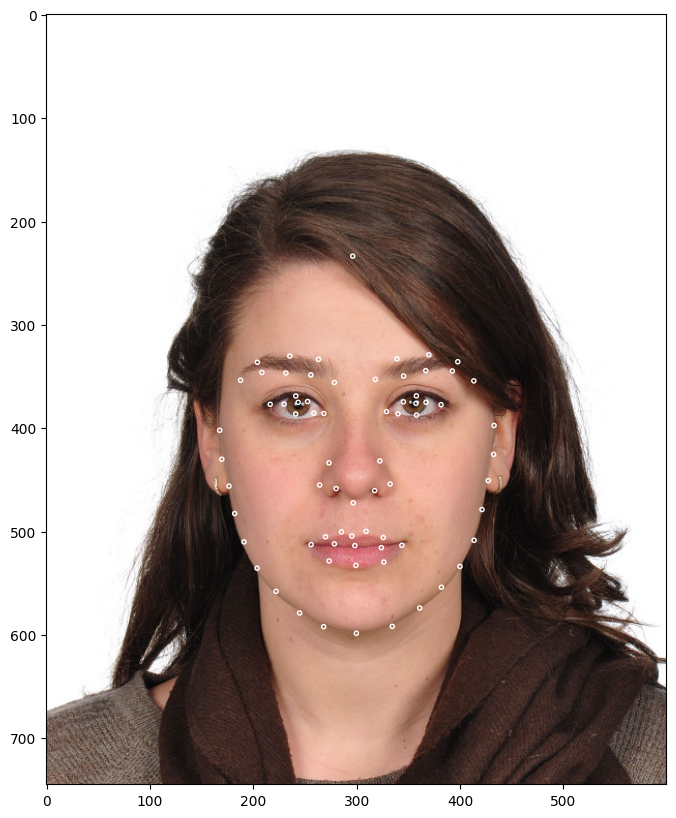

In [ ]:
display_landmarks(proj.reshape(-1,2), im, pixel_scale = False, origin = 'upper_left')